In [1]:
# ==============================================
# Simple Sparse Jump Model Fit for QUAL Factor
# ==============================================

import pandas as pd
import matplotlib.pyplot as plt
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import DataClipperStd
from jumpmodels.plot import plot_regimes_and_cumret
from sklearn.preprocessing import StandardScaler
import os, sys
import matplotlib.lines as mlines

#sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
# sys.path.append('/Users/vlad/Desktop/git/Masters-Thesis-VRI-VP/vic_new')         # for mac vlad
from feature_set_v2 import MergedDataLoader 

In [2]:
# --- Step 1: Load raw data with MergedDataLoader ---
# Define file paths (update if needed)
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "data_new"))
factor_file = os.path.join(base_dir, "1estimation_index_returns.csv")
market_file = os.path.join(base_dir, "1macro_data.csv")

factor_name = "mtum" 

# Load QUAL data
data = MergedDataLoader(
    factor_file=factor_file,
    market_file=market_file,
    factor_col=factor_name,
    ver="v2"      # use factor + macro features
).load()

# Access data components
X = data.X
fac_ret = data.ret_ser
mkt_ret = data.market_ser
active_ret = fac_ret - mkt_ret

# Align indices
common_idx = X.index.intersection(active_ret.index)
X = X.loc[common_idx]
active_ret = active_ret.loc[common_idx]

# Align indices and restrict to data up to 2017
cutoff_date = "2017-01-01"
common_idx = X.index.intersection(active_ret.index)
common_idx = common_idx[common_idx < cutoff_date]
X = X.loc[common_idx]
active_ret = active_ret.loc[common_idx]
active_ret.name = factor_name.upper()   # <-- Correctly label active return series


In [3]:
# --- Step 2: Preprocessing ---
clipper = DataClipperStd(mul=3.0)
scaler = StandardScaler()

X_clip = clipper.fit_transform(X)
X_scaled = scaler.fit_transform(X_clip)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)


In [4]:
# --- Step 3: Model Setup and Fit ---
models = {}
lambdas = [50, 100, 300]

for lam in lambdas:
    model = SparseJumpModel(
        n_components=2,
        jump_penalty=lam,
        max_feats=17,
        cont=False,
        max_iter=30
    )
    model.fit(X_scaled, ret_ser=active_ret, sort_by="cumret")
    models[f"lambda_{lam}"] = model


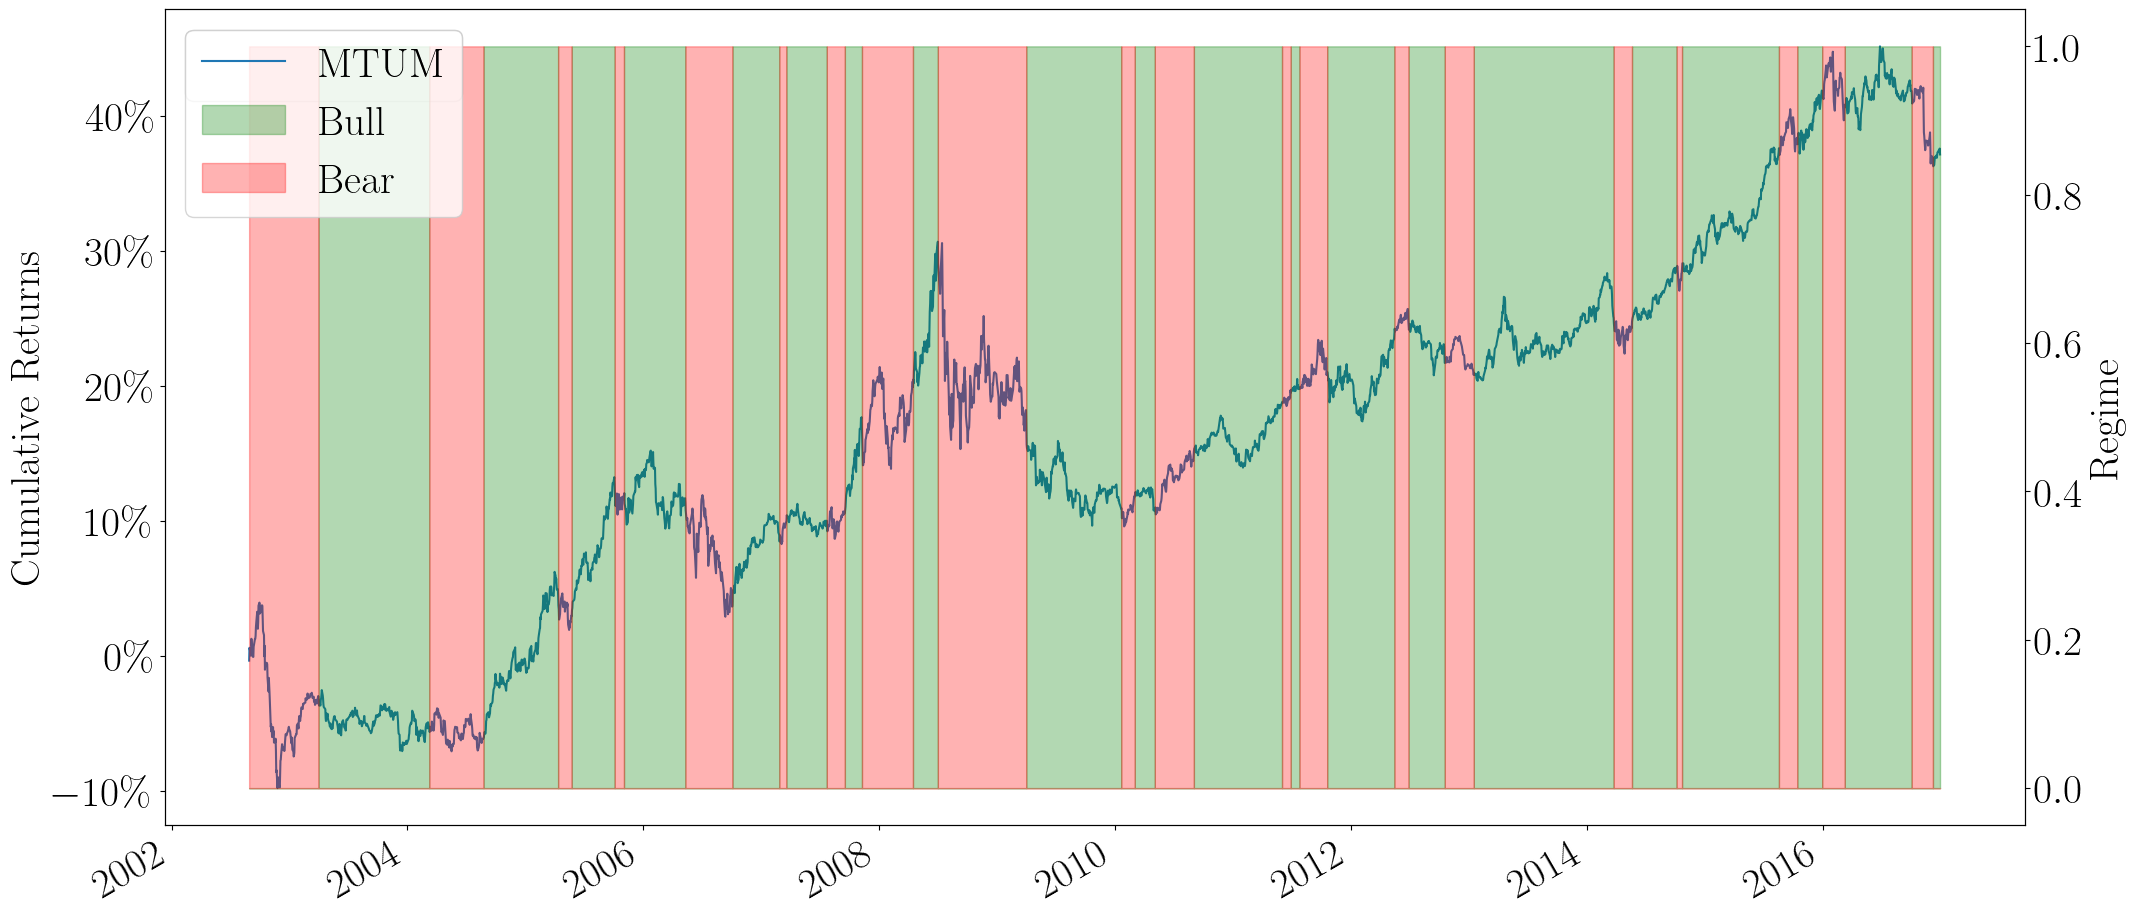

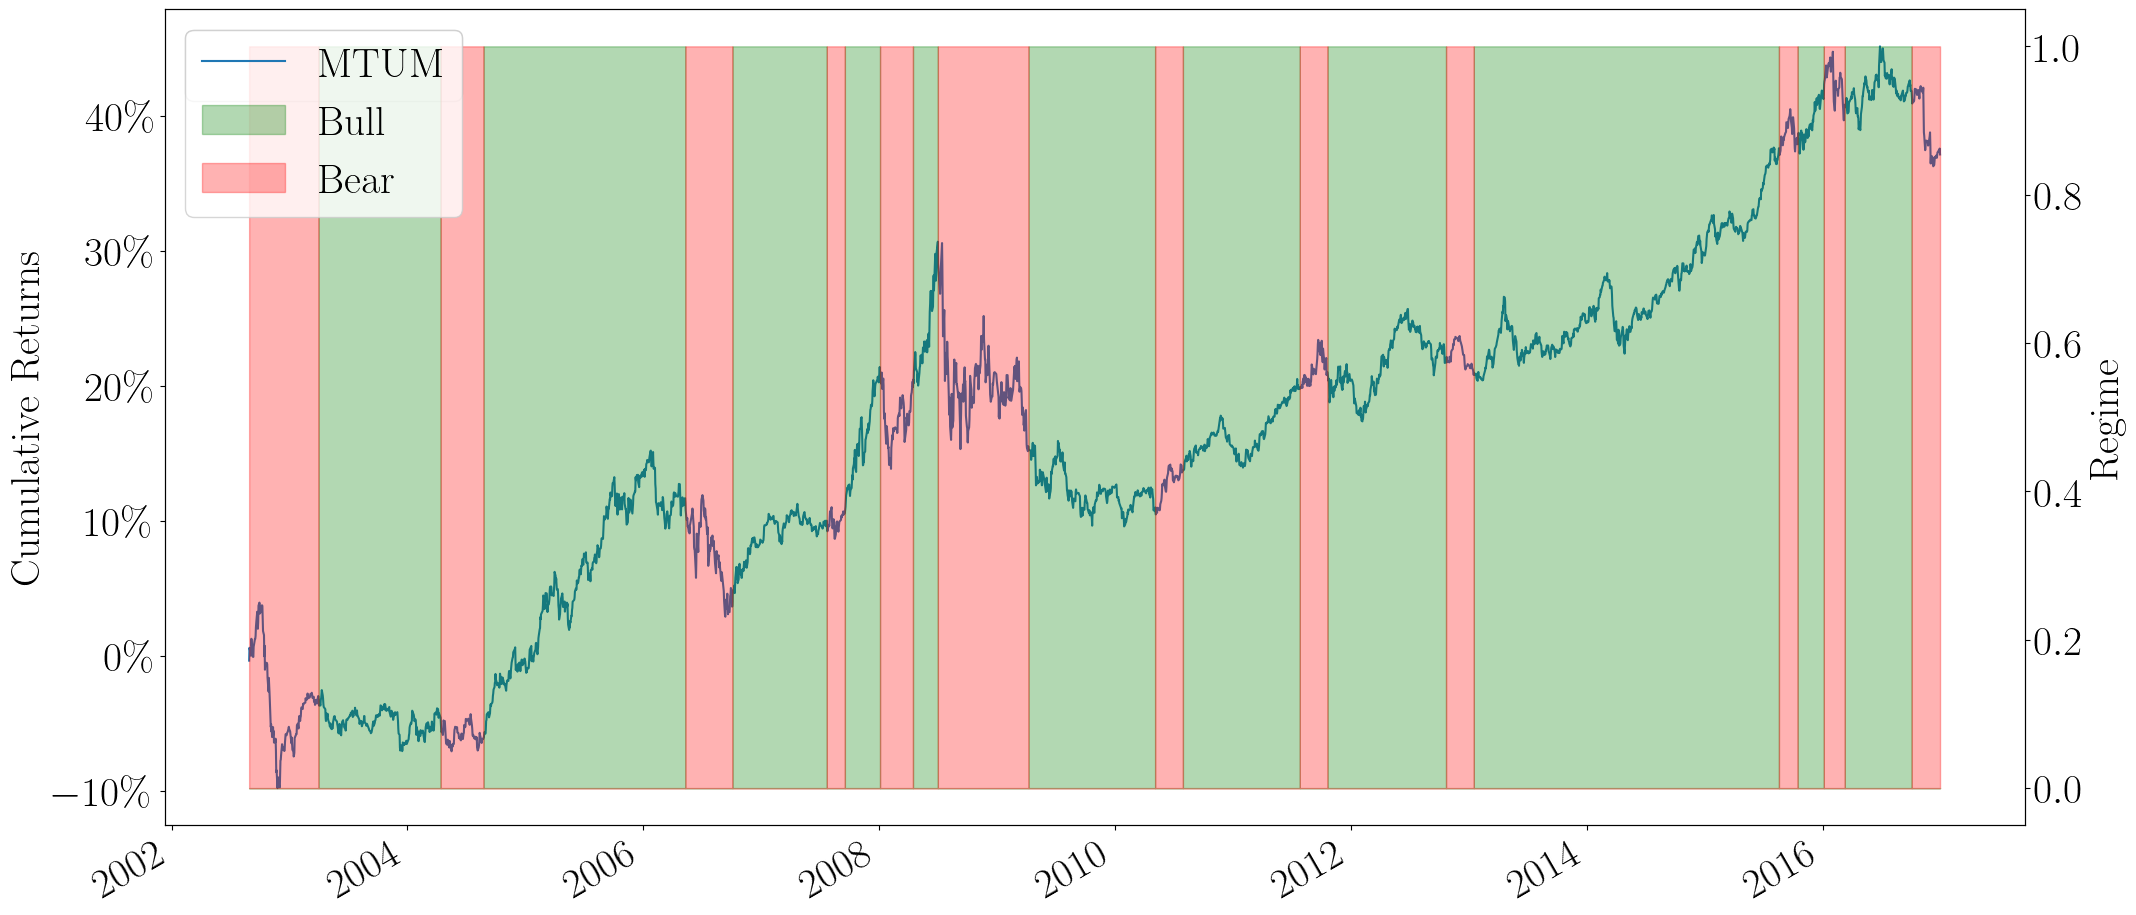

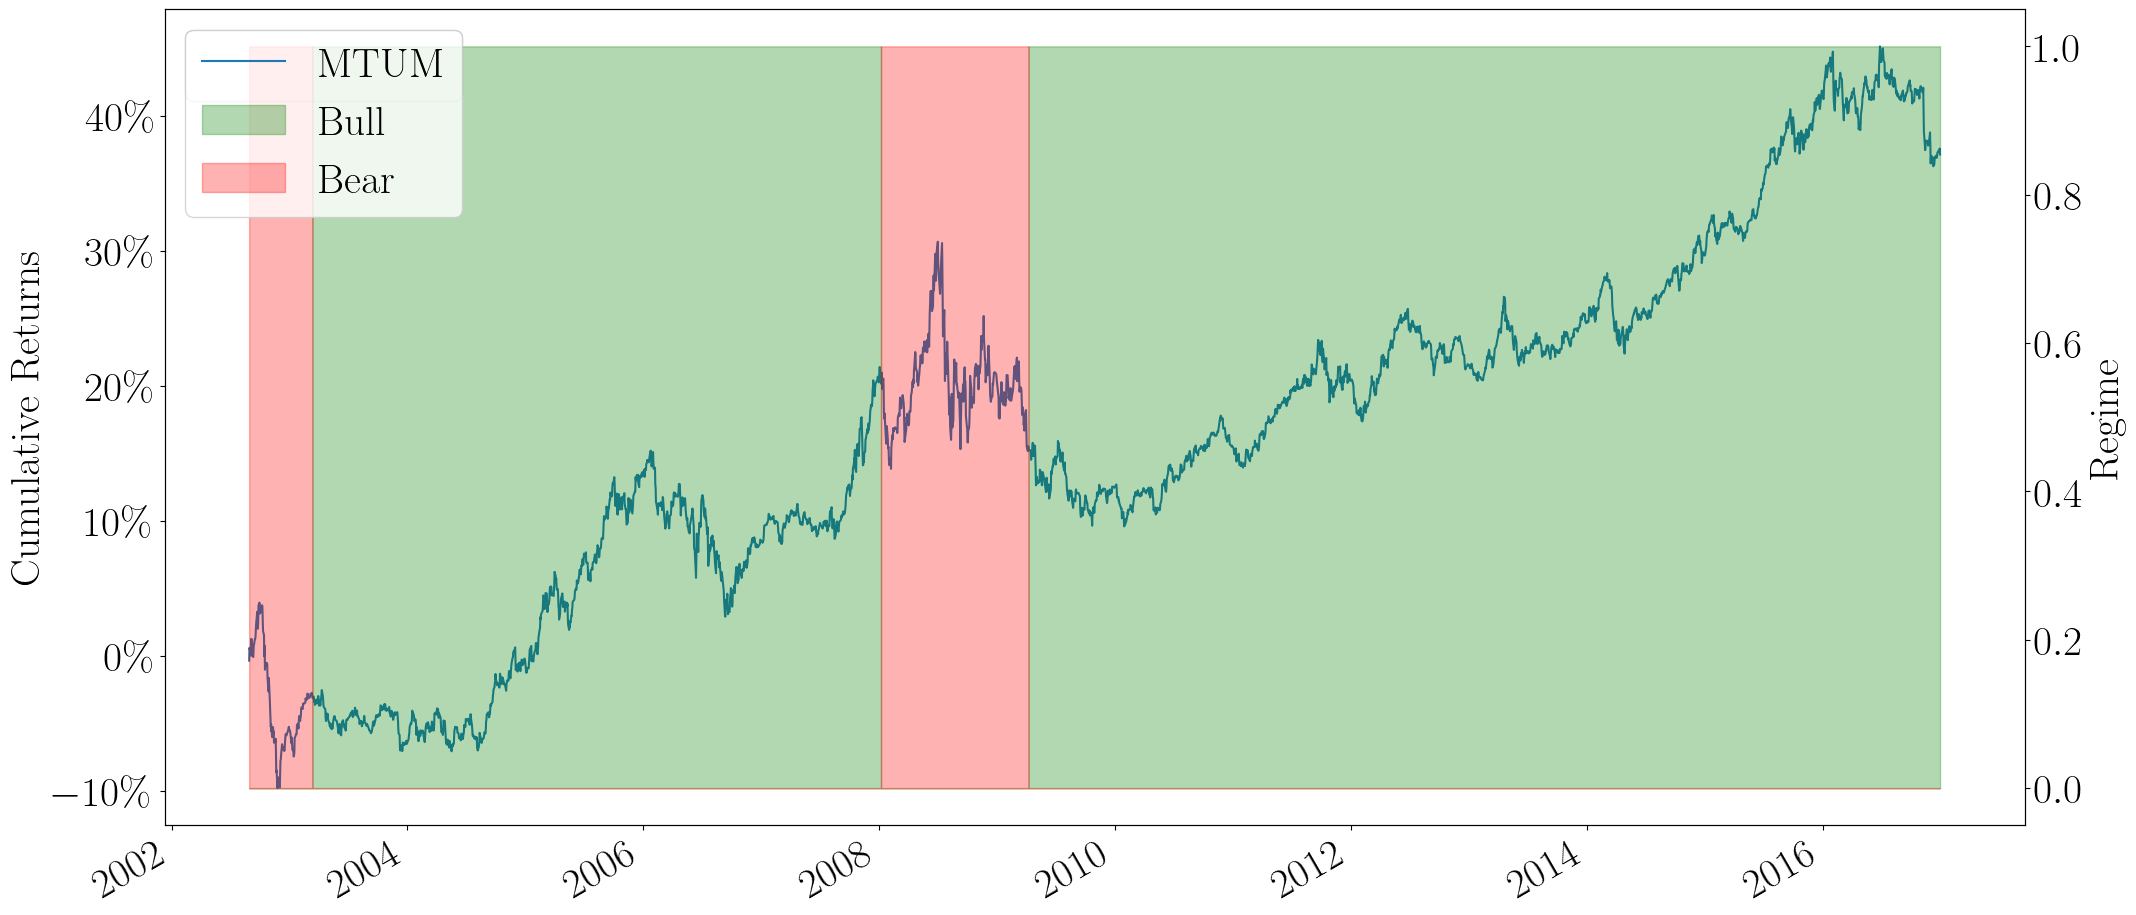

In [13]:
# --- Step 7: Visualization: Regimes and Cumulative Returns with Legend ---
for lam, model in models.items():
    regimes = model.predict(X_scaled)

    fig, ax = plot_regimes_and_cumret(regimes, active_ret, n_c=2)
    # ax.set_title(f"Momentum Factor: Regimes and Cumulative Active Returns ($\\lambda$ = {lam.split('_')[1]})", fontsize=24)
    
    plt.show()


In [8]:
# --- Step 5: Model Setup and Fit ---
feature_models = {}
kappas = [2, 3, 4]

for kap in kappas:
    model = SparseJumpModel(
        n_components=2,
        jump_penalty=100,
        max_feats=kap,
        cont=False,
        max_iter=30
    )
    model.fit(X_scaled, ret_ser=active_ret, sort_by="cumret")
    feature_models[f"kappa_{kap}"] = model  # <-- fixed here


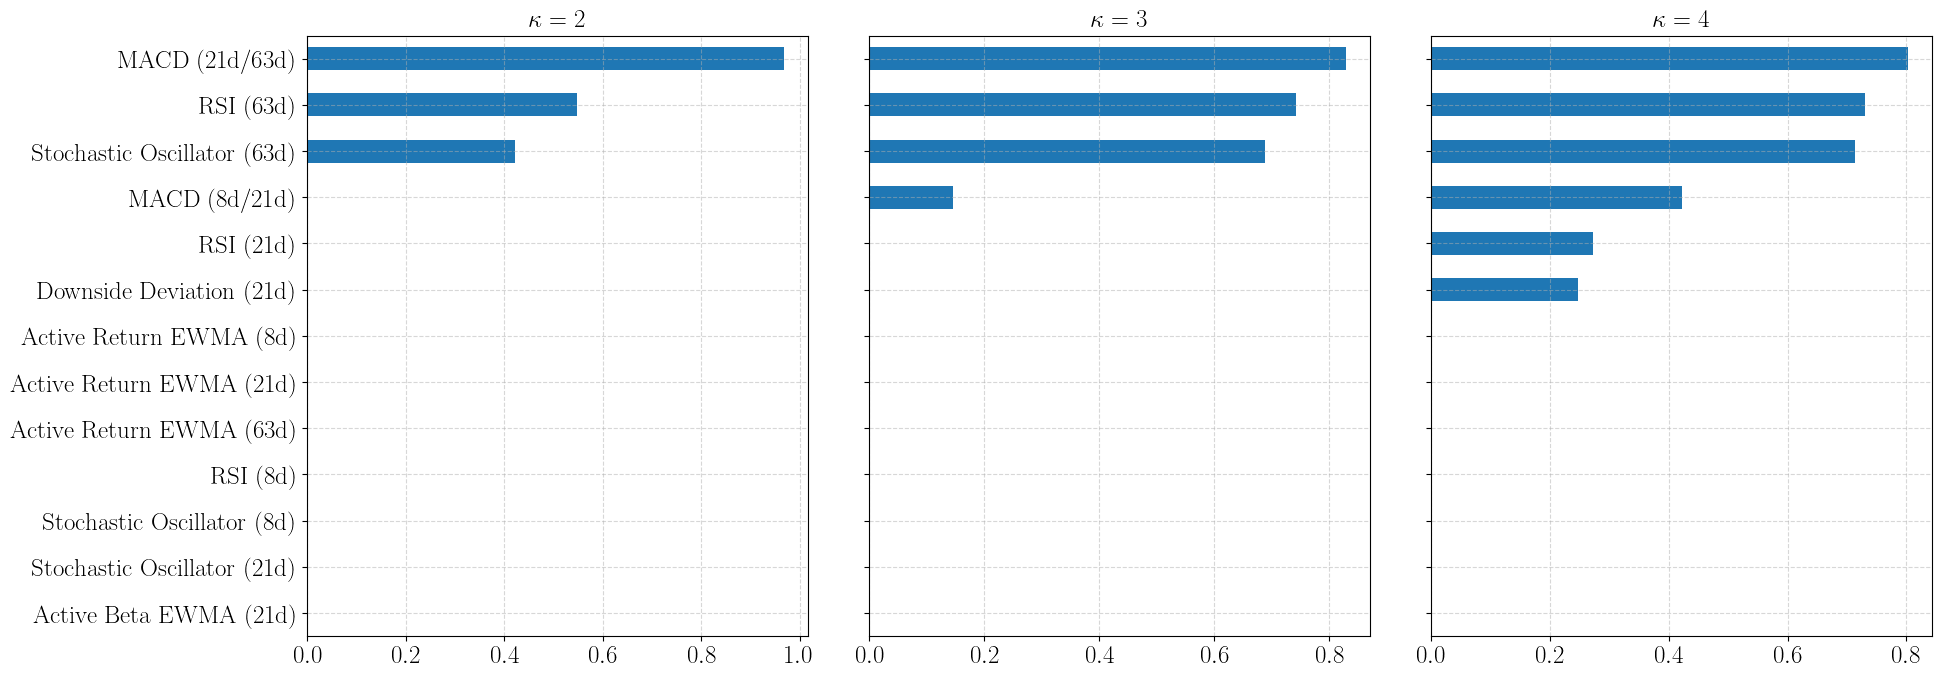

In [11]:
# --- Step 6: Side-by-Side Visualization: Feature Importances by Kappa ---
# Define a clean manual mapping for features
feature_name_map = {
    "ActiveReturn_EWMA_8": "Active Return EWMA (8d)",
    "ActiveReturn_EWMA_21": "Active Return EWMA (21d)",
    "ActiveReturn_EWMA_63": "Active Return EWMA (63d)",
    "RSI_8": "RSI (8d)",
    "RSI_21": "RSI (21d)",
    "RSI_63": "RSI (63d)",
    "StochOsc_%K_8": "Stochastic Oscillator (8d)",
    "StochOsc_%K_21": "Stochastic Oscillator (21d)",
    "StochOsc_%K_63": "Stochastic Oscillator (63d)",
    "MACD_8_21": "MACD (8d/21d)",
    "MACD_21_63": "MACD (21d/63d)",
    "DownsideDev_21": "Downside Deviation (21d)",
    "ActiveMarketBeta_21": "Active Beta EWMA (21d)",
}

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for ax, (kappa, model) in zip(axes, feature_models.items()):
    feat_weights = model.feat_weights.copy()
    # Rename features nicely
    feat_weights.index = feat_weights.index.map(lambda x: feature_name_map.get(x, x))
    feat_weights.sort_values(ascending=False).plot(kind="barh", ax=ax)  # sort high to low
    ax.set_title(fr"$\kappa={kappa.split('_')[1]}$", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.invert_yaxis()
    ax.grid(True, linestyle='--', alpha=0.5)

# fig.suptitle(r"Momentum Factor: Feature Importance ($\lambda=100$, Varying $\kappa$)", fontsize=24)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()